<a href="https://colab.research.google.com/github/Tieck-IT/GAN_paper_study/blob/main/GAN/tf_GAN%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://velog.io/@wo7864/GAN-%EC%BD%94%EB%93%9C%EB%A5%BC-%ED%86%B5%ED%95%9C-%EC%9D%B4%ED%95%B41

In [ ]:
# python 표준 라이브러리
import os
import time
import glob

# 오픈소스 라이브러리
import tensorflow as tf
from tensorflow.keras import layers
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL

# Colab Notebook Library
from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 활성화 함수 Tanh는 sigmoid의 좋은 대체제
- vanishing gradient problem를 완화
- 범위 : [-1,1]
- 중앙값 : 0

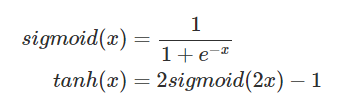

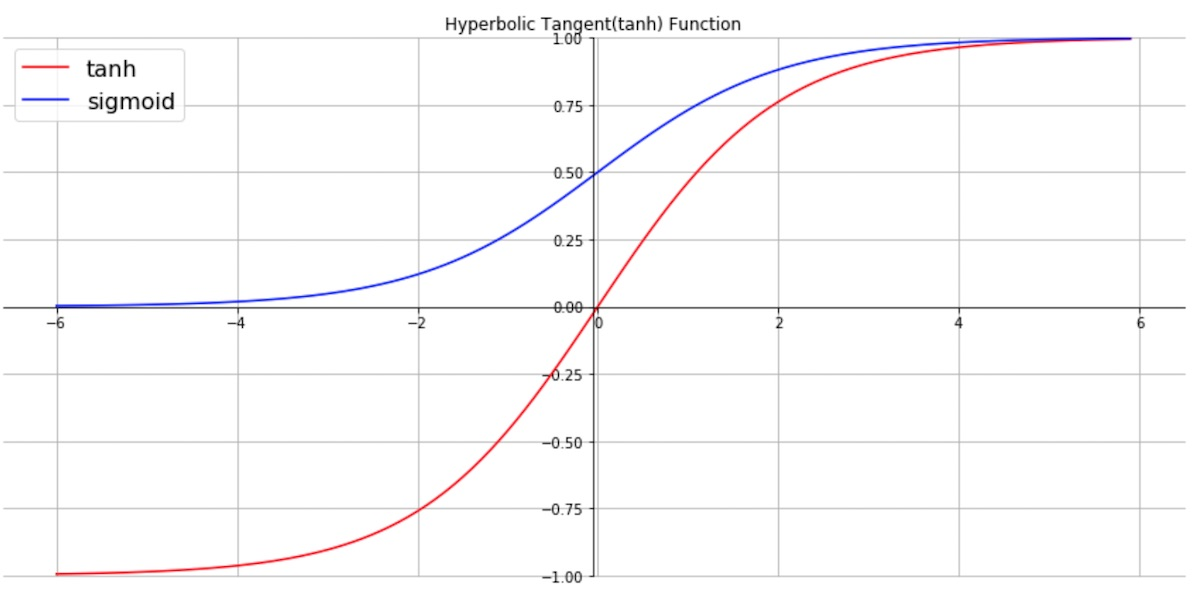

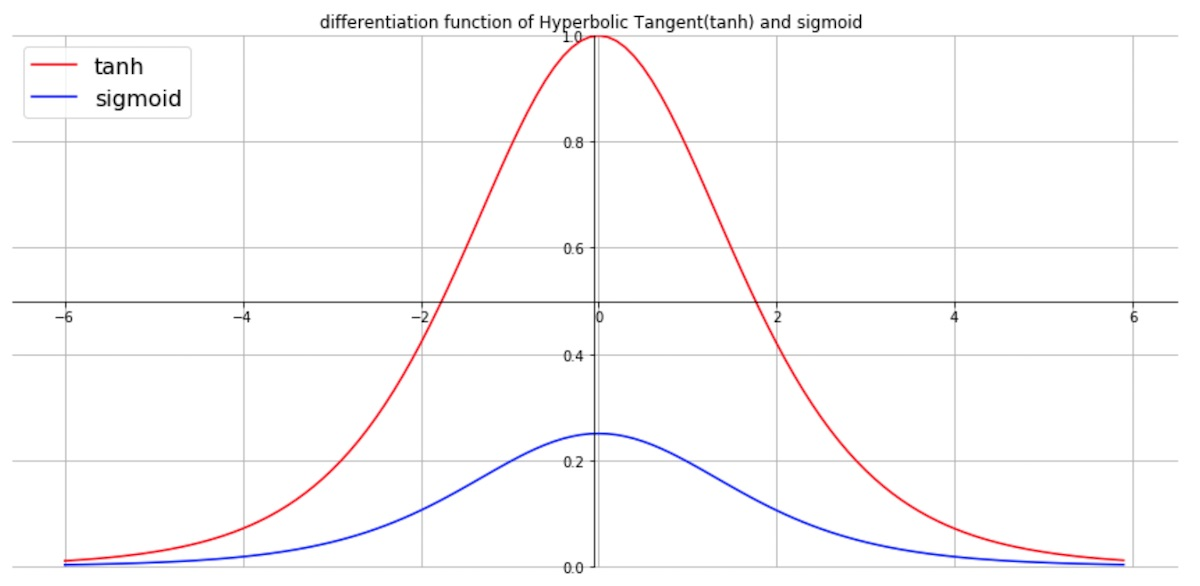

# Generator , Discriminator 생성

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(100,)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(28*28*1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

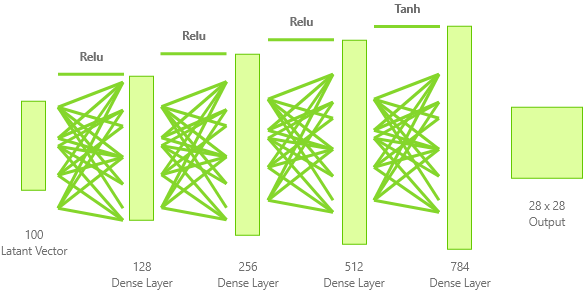

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))

    return model

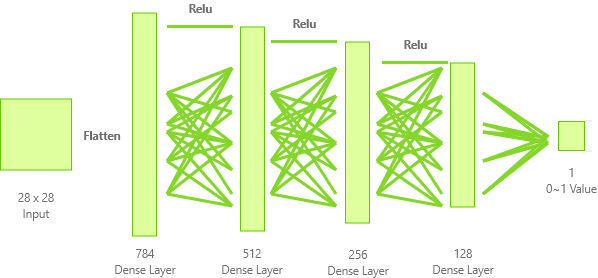

# Loss 정의
- Generator와 Discriminator 모두 loss를 계산 할 때, Discriminator의 출력 값을 기준으로 합니다. 따라서 Discriminator의 출력이 0 또는 1으로 수렴해야하기에, BinaryCrossentropy 를 채택합니다.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- Generator의 목적은 Generator가 생성한 이미지를 Discriminator가 1(진짜이미지)으로 판별하도록하는 것입니다. 따라서 Generator의 Loss는 생성한 이미지를 Discriminator가 판별한 결과를 입력으로 받아서, 그 값이 얼마나 1에서 멀리있는가 를 기준으로 Loss를 결정합니다.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- logit=True  
https://hwiyong.tistory.com/335

# 훈련 객체 선언

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
# sigmoid 또는 linear를 거쳐서 확률이 아닌 값이 나오게 된다면, logit=True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
noise = tf.random.normal([BATCH_SIZE, noise_dim])

In [ ]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

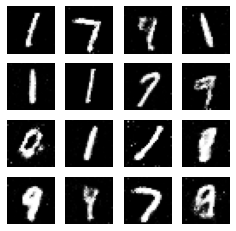

CPU times: user 6min 56s, sys: 19.6 s, total: 7min 16s
Wall time: 6min 31s


In [ ]:
%%time
train(train_dataset, EPOCHS)

https://media.vlpt.us/images/wo7864/post/fb6b083d-4264-4089-b0ff-8f45f1245da5/GAN_RESULTS.gif